**It's based on tanlikesmath's starter notebook at https://www.kaggle.com/tanlikesmath/petfinder-pawpularity-eda-fastai-starter. My teammate Stefano did the most work.**

# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

In this competition, we will use machine learning to predict the "pawpularity" of a pet using images and metadata. If successful, solutions will be adapted into AI tools that will guide shelters and rescuers around the world to improve the appeal of their pet profiles, automatically enhancing photo quality and recommending composition improvements. As a result, stray dogs and cats can find families much faster, and these tools will help improve animal welfare.

In this notebook, I will present a quick 'n dirty EDA and a (image-only, for now) fastai starter. 

**As of 10/26, it's currently the best-scoring notebook for the competition, beating 10-fold ensemble models that are bigger while only using a single and smaller model.**

V1: Change get_data(fold) to correct K-Fold, use is_valid for validation data

## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from fastai.vision.all import *

In [2]:
set_seed(999, reproducible=True)
BATCH_SIZE = 32

Let's check what data is available to us:

In [3]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
# dataset_path.ls()

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

In [4]:
train_df = pd.read_csv(dataset_path/'train.csv')
# train_df.head()

The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

Let's do some quick processing of the image filenames to make it easier to access:

In [5]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
# train_df.head()

Note that the Pawpularity score is an integer, so in addition to being a regression problem, it could also be treated as a 100-class classification problem. Alternatively, it can be treated as a binary classification problem if the Pawpularity Score is normalized between 0 and 1:

In [6]:
train_df['norm_score'] = train_df['Pawpularity']/100

## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

In [7]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [8]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [9]:
#Sturges' rule
num_bins = int(np.floor(1+np.log2(len(train_df))))
# num_bins

<AxesSubplot:>

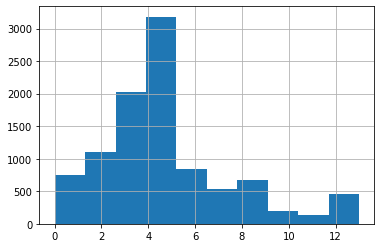

In [10]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts()
# train_df.fold.value_counts().plot.bar()

1    1983
0    1983
3    1982
2    1982
4    1982
Name: fold, dtype: int64

In [12]:
# train_df[train_df['fold']==0].head()

In [13]:
# train_df[train_df['fold']==0]['bins'].value_counts()

In [14]:
# train_df[train_df['fold']==1]['bins'].value_counts()

In [15]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [16]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([DeterministicFlip(),
#                                                           Brightness(),Contrast(),Hue(),Saturation(),
                                                          RandomErasing(p=.5, max_count=5, min_aspect=0.5, sl=0.0, sh=0.3)
#                                                           RandomResizedCrop(224, min_scale=0.1, max_scale=0.8, ratio=(0.75, 1.3333))
                                                         ])) #pass in batch_tfms
    
    return dls


In [17]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [18]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [19]:
test_df = pd.read_csv(dataset_path/'test.csv')

In [20]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
# train_df['norm_score'] = train_df['Pawpularity']/100

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=9.070797386812046e-05)

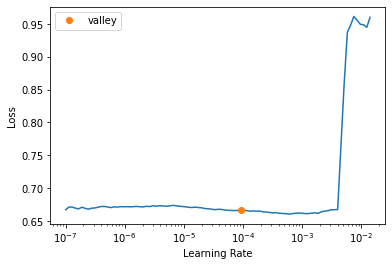

In [21]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [22]:
import gc

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.656056,0.644947,18.002098,06:33
1,0.648756,0.640414,17.389685,06:32
2,0.645829,0.641401,17.584831,06:34
3,0.641122,0.639110,17.267942,06:34
4,0.637624,0.638842,17.212130,06:33


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.644946813583374.
Better model found at epoch 1 with valid_loss value: 0.6404141187667847.
Better model found at epoch 3 with valid_loss value: 0.6391099095344543.
Better model found at epoch 4 with valid_loss value: 0.6388416886329651.


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653839,0.645673,18.066792,06:33
1,0.648762,0.641643,17.550621,06:33
2,0.644179,0.640709,17.400677,06:32
3,0.639402,0.640700,17.393770,06:32
4,0.637093,0.640769,17.400715,06:33


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.645672619342804.
Better model found at epoch 1 with valid_loss value: 0.6416429281234741.
Better model found at epoch 2 with valid_loss value: 0.6407089233398438.
Better model found at epoch 3 with valid_loss value: 0.6406999230384827.


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655449,0.647996,18.351480,06:33
1,0.645909,0.642568,17.611053,06:32
2,0.642583,0.642056,17.547373,06:33
3,0.640552,0.641400,17.464550,06:33
4,0.637467,0.641572,17.495155,06:34


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6479958295822144.
Better model found at epoch 1 with valid_loss value: 0.6425684690475464.
Better model found at epoch 2 with valid_loss value: 0.6420562267303467.
Better model found at epoch 3 with valid_loss value: 0.6413998007774353.


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655608,0.650980,18.583778,06:34
1,0.647569,0.640749,17.399002,06:34
2,0.642718,0.641068,17.464771,06:33
3,0.643873,0.640054,17.322260,06:34
4,0.637708,0.640148,17.316275,06:33


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6509795188903809.
Better model found at epoch 1 with valid_loss value: 0.6407493948936462.
Better model found at epoch 3 with valid_loss value: 0.6400535106658936.


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655379,0.645710,18.205097,06:35
1,0.644670,0.644775,18.028942,06:33
2,0.641548,0.641019,17.573793,06:33
3,0.639116,0.640614,17.509281,06:34
4,0.634904,0.640573,17.494068,06:34


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6457101106643677.
Better model found at epoch 1 with valid_loss value: 0.6447746753692627.
Better model found at epoch 2 with valid_loss value: 0.6410188674926758.
Better model found at epoch 3 with valid_loss value: 0.64061439037323.
Better model found at epoch 4 with valid_loss value: 0.6405728459358215.


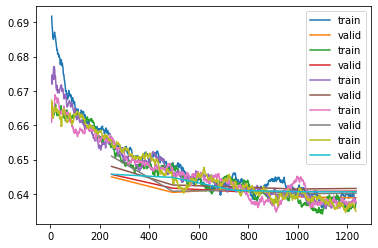

In [23]:
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), 
                                      EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2),
                                      MixUp(0.2)]) 
    
    learn.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    learn.export(f'model_fold_{i}.pkl')
    learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([DeterministicFlip(),
#                                                           Brightness(),Contrast(),
#                                                           Hue(),Saturation()
                                                          RandomErasing(p=.5, max_count=5, min_aspect=0.5, sl=0.0, sh=0.3)
#                                                           RandomResizedCrop(224, min_scale=0.1, max_scale=0.8, ratio=(0.75, 1.3333))
                                                         ])) # validation augmentation?
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [24]:
# all_preds

In [25]:
np.mean(np.stack(all_preds*100))

0.3978609

In [26]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [27]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.265060
1,43a2262d7738e3d420d453815151079e,40.195004
2,4e429cead1848a298432a0acad014c9d,39.776222
3,80bc3ccafcc51b66303c2c263aa38486,40.053550
4,8f49844c382931444e68dffbe20228f4,40.133800


In [28]:
#path = './models'
#learn1 = load_learner('model_fold_2.pkl')

# Model training

Let's train a Swin Transformer model as a baseline. We will use the wonderful timm package by Ross Wightman to define the model. Since this competition doesn't allow internet access, I have added the pretrained weights from timm as a dataset, and the below code cell will allow timm to find the file:

Let's now define the model.

Let's also define the metric we will use. Note that we multiply by 100 to get a relevant RMSE for Pawpularity Score prediction, not prediction of the normalized score.

In fastai, the trainer class is the `Learner`, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc. Let's define the `Learner` for this task, and also use mixed precision. Note that we use `BCEWithLogitsLoss` to treat this as a classification problem.

We are now provided with a Learner object. In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

lrは上記のコードから提案された値に変更する

Let's now fine-tune the model with the desired learning rate of 2e-5. We'll save the best model and use the early stopping callback.

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

## Inference

It's very simple to perform inference with fastai. We preprocess the test CSV in the same way as the train CSV, and the `dls.test_dl` function allows you to create test dataloader using the same pipeline we defined earlier.

In [29]:
# test_df = pd.read_csv(dataset_path/'test.csv')
# test_df.head()

In [30]:
# test_df['Pawpularity'] = [1]*len(test_df)
# test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
# test_df = test_df.drop(columns=['Id'])
# train_df['norm_score'] = train_df['Pawpularity']/100

In [31]:
# dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=32, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
# test_dl = dls.test_dl(test_df)

In [32]:
# test_dl.show_batch()

We can easily confirm that the test_dl is correct (the example test images provided are just noise so this is expected):

Now let's pass the dataloader to the model and get predictions. Here I am using 5x test-time augmentation which further improves model performance.

In [33]:
#preds, _ = learn1.tta(dl=test_dl, n=5, beta=0)

Let's make a submission with these predictions!

In [34]:
# sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
# sample_df['Pawpularity'] = preds.float().numpy()*100
# sample_df.to_csv('submission.csv',index=False)

In [35]:
#pd.read_csv('submission.csv').head()

Now, **WE ARE DONE!**

If you enjoyed this notebook, please give it an upvote. 

Stay tuned for improvements to this notebook, potentially including a version that uses the metadata as well.

If you have any questions or suggestions, please leave a comment!